<a href="https://colab.research.google.com/github/yudumpacin/Earthquakes-in-Turkey/blob/main/Kandilli_Earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Earthquakes in Turkey**

Kandilli Rasathanesi webpage gives information about last 500 earthquakes in Turkey and near Turkey, these information is updated regularly. I will analyze this data using Pyhton libraries.

In [245]:
#Necessary Libraries are imported
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import requests as req
import matplotlib.pyplot as plt
import seaborn as sn
import folium
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
from sklearn.preprocessing import StandardScaler
import os.path, time, datetime
from sklearn.ensemble import IsolationForest
from scipy import stats


Last Runtime:

In [246]:
import datetime
now = datetime.datetime.utcnow()+datetime.timedelta(hours=3)
last_modified_time = now.strftime("%Y-%m-%d %H:%M:%S")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

2021-06-27 15:05:25


# 1- Data

Earthquake data is extracted from Kandilli Rasathanesi wep page.
Data consists of last 500 earthquake happened in Turkey. Each data sample has these features; 
* Tarih (date), 
* Enlem (latitude), 
* Boylam (longtitude), 
* Derinlik(depth), 
* ML(magnitute), 
* Yer(name of place), and 
* Çözüm Niteliği (attribute of solution (primary,revised))

### Extract the  Data from webpage

In [247]:
# I will extract data with Beautifoulsoup and request library
link = 'http://www.koeri.boun.edu.tr/scripts/lst5.asp'
re = req.get(link)
soup = bs(re.content)

In [248]:
data_all = soup.find('pre').get_text().split('\r\n')

In [249]:
feature = data_all[5:6]

In [250]:
data = data_all[7:]

In [251]:
data[:5]

['2021.06.27 14:57:53  36.2388   27.1667       24.0      -.-  1.9  -.-   AKDENIZ                                           İlksel',
 '2021.06.27 14:17:25  36.3288   27.0918       20.0      -.-  3.2  -.-   AKDENIZ                                           İlksel',
 '2021.06.27 14:11:31  36.3502   27.2070       25.4      -.-  1.9  -.-   ONIKI ADALAR (AKDENIZ)                            İlksel',
 '2021.06.27 13:46:10  36.4165   27.0785        9.9      -.-  2.0  -.-   ONIKI ADALAR (AKDENIZ)                            İlksel',
 '2021.06.27 13:42:21  36.2845   27.0868       23.9      -.-  1.8  -.-   AKDENIZ                                           İlksel']

In [252]:
feature

['Tarih      Saat      Enlem(N)  Boylam(E) Derinlik(km)  MD   ML   Mw    Yer                                             Çözüm Niteliği']

In [253]:
#drop "çözüm niteliği" feature, since  çözüm niteliği (attribute of solution ), it is whether primary, i.e. the info is given without revized, or revized
feature = ['Tarih' ,'Saat' , 'Enlem(N)'  ,'Boylam(E)','Derinlik(km)','MD','ML','Mw','Yer']

In [254]:
df = pd.DataFrame(data)

In [255]:
df = df[0].str.split(' ', expand=True)

In [256]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77
0,2021.06.27,14:57:53,,36.2388,,,27.1667,,,,,,,24.0,,,,,,-.-,,1.9,,-.-,,,AKDENIZ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,İlksel,None,None,None,None,None,None,None,None
1,2021.06.27,14:17:25,,36.3288,,,27.0918,,,,,,,20.0,,,,,,-.-,,3.2,,-.-,,,AKDENIZ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,İlksel,None,None,None,None,None,None,None,None
2,2021.06.27,14:11:31,,36.3502,,,27.2070,,,,,,,25.4,,,,,,-.-,,1.9,,-.-,,,ONIKI,ADALAR,(AKDENIZ),,,,,,,,,,,,,,,,,,,,,,,,,,,,İlksel,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,2021.06.27,13:46:10,,36.4165,,,27.0785,,,,,,,,9.9,,,,,,-.-,,2.0,,-.-,,,ONIKI,ADALAR,(AKDENIZ),,,,,,,,,,,,,,,,,,,,,,,,,,,,İlksel,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,2021.06.27,13:42:21,,36.2845,,,27.0868,,,,,,,23.9,,,,,,-.-,,1.8,,-.-,,,AKDENIZ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,İlksel,None,None,None,None,None,None,None,None


In [257]:
df = df.iloc[:,:29]

In [258]:
df.drop([2,4,5,7,	8	,9,	10,	11	,12,15,	16	,17,	18],axis=1,inplace=True)
df[13] = df[13]+df[14]
df[19] = df[19]+df[20]
df[21] = df[21]+df[22]
df[23] = df[23]+df[24]
df[26] = df[26]+' '+df[27]+' '+df[28]

In [259]:
df.drop([14],axis=1,inplace=True)
df.drop([20],axis=1,inplace=True)
df.drop([22],axis=1,inplace=True)
df.drop([24],axis=1,inplace=True)
df.drop([25],axis=1,inplace=True)
df.drop([27],axis=1,inplace=True)
df.drop([28],axis=1,inplace=True)

In [260]:
df.columns=feature

In [261]:
df.head()

,Tarih,Saat,Enlem(N),Boylam(E),Derinlik(km),MD,ML,Mw,Yer
0,2021.06.27,14:57:53,36.2388,27.1667,24.0,-.-,1.9,-.-,AKDENIZ
1,2021.06.27,14:17:25,36.3288,27.0918,20.0,-.-,3.2,-.-,AKDENIZ
2,2021.06.27,14:11:31,36.3502,27.2070,25.4,-.-,1.9,-.-,ONIKI ADALAR (AKDENIZ)
3,2021.06.27,13:46:10,36.4165,27.0785,9.9,-.-,2.0,-.-,ONIKI ADALAR
4,2021.06.27,13:42:21,36.2845,27.0868,23.9,-.-,1.8,-.-,AKDENIZ


# 2. Preprocessing

In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tarih         502 non-null    object
 1   Saat          500 non-null    object
 2   Enlem(N)      500 non-null    object
 3   Boylam(E)     500 non-null    object
 4   Derinlik(km)  500 non-null    object
 5   MD            500 non-null    object
 6   ML            500 non-null    object
 7   Mw            500 non-null    object
 8   Yer           500 non-null    object
dtypes: object(9)
memory usage: 35.4+ KB


In [263]:
df.replace('-.-',np.NAN,inplace=True)

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tarih         502 non-null    object
 1   Saat          500 non-null    object
 2   Enlem(N)      500 non-null    object
 3   Boylam(E)     500 non-null    object
 4   Derinlik(km)  500 non-null    object
 5   MD            1 non-null      object
 6   ML            499 non-null    object
 7   Mw            17 non-null     object
 8   Yer           500 non-null    object
dtypes: object(9)
memory usage: 35.4+ KB


In [265]:
#MD and Mw values are mostly null, so drop these two columns from dataframe
df.drop(['MD','Mw'],axis=1,inplace=True)

In [266]:
df.head()

,Tarih,Saat,Enlem(N),Boylam(E),Derinlik(km),ML,Yer
0,2021.06.27,14:57:53,36.2388,27.1667,24.0,1.9,AKDENIZ
1,2021.06.27,14:17:25,36.3288,27.0918,20.0,3.2,AKDENIZ
2,2021.06.27,14:11:31,36.3502,27.2070,25.4,1.9,ONIKI ADALAR (AKDENIZ)
3,2021.06.27,13:46:10,36.4165,27.0785,9.9,2.0,ONIKI ADALAR
4,2021.06.27,13:42:21,36.2845,27.0868,23.9,1.8,AKDENIZ


In [267]:
#convert numerical features
df['Enlem(N)'] = pd.to_numeric(df['Enlem(N)'])
df['Boylam(E)'] = pd.to_numeric(df['Boylam(E)'])
df['Derinlik(km)'] = pd.to_numeric(df['Derinlik(km)'])
df['ML'] = pd.to_numeric(df['ML'])

In [268]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Tarih         502 non-null    object 
 1   Saat          500 non-null    object 
 2   Enlem(N)      500 non-null    float64
 3   Boylam(E)     500 non-null    float64
 4   Derinlik(km)  499 non-null    float64
 5   ML            499 non-null    float64
 6   Yer           500 non-null    object 
dtypes: float64(4), object(3)
memory usage: 27.6+ KB


In [269]:
#convert date feature
df['TarihSaat'] = df['Tarih'] +' '+ df['Saat']
df['TarihSaat'] = pd.to_datetime(df['TarihSaat'])

In [270]:
df.head()

,Tarih,Saat,Enlem(N),Boylam(E),Derinlik(km),ML,Yer,TarihSaat
0,2021.06.27,14:57:53,36.2388,27.1667,24.0,1.9,AKDENIZ,2021-06-27 14:57:53
1,2021.06.27,14:17:25,36.3288,27.0918,20.0,3.2,AKDENIZ,2021-06-27 14:17:25
2,2021.06.27,14:11:31,36.3502,27.2070,25.4,1.9,ONIKI ADALAR (AKDENIZ),2021-06-27 14:11:31
3,2021.06.27,13:46:10,36.4165,27.0785,9.9,2.0,ONIKI ADALAR,2021-06-27 13:46:10
4,2021.06.27,13:42:21,36.2845,27.0868,23.9,1.8,AKDENIZ,2021-06-27 13:42:21


In [271]:
df['Date'] = pd.to_datetime(df['TarihSaat'])
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
df['hour'] = pd.DatetimeIndex(df['Date']).hour
df['minute'] = pd.DatetimeIndex(df['Date']).minute
df['seconds'] = pd.DatetimeIndex(df['Date']).second

In [272]:
df = df.drop(['Tarih','Saat','Date'], axis = 1) 

In [273]:
df.isna().sum()

Enlem(N)        2
Boylam(E)       2
Derinlik(km)    3
ML              3
Yer             2
TarihSaat       2
year            2
month           2
day             2
hour            2
minute          2
seconds         2
dtype: int64

In [274]:
df = df.dropna()

# 2. EDA (Exploratory Data Analysis)


In [275]:
df.head()

,Enlem(N),Boylam(E),Derinlik(km),ML,Yer,TarihSaat,year,month,day,hour,minute,seconds
0,36.2388,27.1667,24.0,1.9,AKDENIZ,2021-06-27 14:57:53,2021.0,6.0,27.0,14.0,57.0,53.0
1,36.3288,27.0918,20.0,3.2,AKDENIZ,2021-06-27 14:17:25,2021.0,6.0,27.0,14.0,17.0,25.0
2,36.3502,27.2070,25.4,1.9,ONIKI ADALAR (AKDENIZ),2021-06-27 14:11:31,2021.0,6.0,27.0,14.0,11.0,31.0
3,36.4165,27.0785,9.9,2.0,ONIKI ADALAR,2021-06-27 13:46:10,2021.0,6.0,27.0,13.0,46.0,10.0
4,36.2845,27.0868,23.9,1.8,AKDENIZ,2021-06-27 13:42:21,2021.0,6.0,27.0,13.0,42.0,21.0


In [276]:
print(f'There are {df.shape[0]} earthquakes between {max(df.TarihSaat)-min(df.TarihSaat)} in {len(df.Yer.value_counts())} different places near Turkey')

There are 499 earthquakes between 4 days 08:06:02 in 132 different places near Turkey



ONIKI ADALAR (AKDENIZ) is the place where most earthquakes happen, but the mean of ML is 1.9, that is small magnitute earthquakes take place in this reagon frequently

In [277]:
df.groupby(df['Yer'])['ML'].describe().sort_values(by = 'count', ascending= False)[0:10]

,count,mean,std,min,25%,50%,75%,max
Yer,,,,,,,,
ONIKI ADALAR (AKDENIZ),94.0,1.911702,0.252666,1.4,1.700,1.90,2.100,2.6
AKDENIZ,80.0,2.028750,0.410370,1.3,1.700,1.95,2.300,3.2
AKDENIZ,74.0,2.254054,0.496340,1.5,1.900,2.10,2.500,3.9
ONIKI ADALAR,60.0,2.085000,0.316670,1.5,1.800,2.10,2.200,3.1
KUSADASI KORFEZI,16.0,1.937500,0.420912,1.3,1.650,1.95,2.100,2.7
EGE DENIZI,8.0,1.950000,0.307060,1.6,1.775,1.90,2.025,2.6
KUSBAYIRI-KARAKOCAN (ELAZIG),7.0,2.128571,0.349830,1.6,1.900,2.20,2.350,2.6
KUSBAYIRI-KARAKOCAN (ELAZIG),5.0,2.960000,1.310725,2.3,2.300,2.40,2.500,5.3
EGE DENIZI,5.0,1.780000,0.178885,1.6,1.600,1.80,1.900,2.0


Now, explore earthquakes bigger than 3 ML, this time AKDENİZ region is the place where most earthquakes happen

In [278]:
df[df.ML>3].groupby(df['Yer'])['ML'].describe().sort_values(by = ['count','mean'], ascending= False)[0:10]

,count,mean,std,min,25%,50%,75%,max
Yer,,,,,,,,
AKDENIZ,6.0,3.333333,0.294392,3.1,3.2,3.2,3.35,3.9
AKDENIZ,3.0,3.133333,0.057735,3.1,3.1,3.1,3.15,3.2
KUSBAYIRI-KARAKOCAN (ELAZIG),1.0,5.300000,NaN,5.3,5.3,5.3,5.30,5.3
AGARTI (VAN),1.0,3.500000,NaN,3.5,3.5,3.5,3.50,3.5
BILEKKAYA-YAYLADERE (BINGOL),1.0,3.200000,NaN,3.2,3.2,3.2,3.20,3.2
GIRIT ADASI ACIKLARI,1.0,3.200000,NaN,3.2,3.2,3.2,3.20,3.2
ONIKI ADALAR,1.0,3.100000,NaN,3.1,3.1,3.1,3.10,3.1
TAVAKLI ACIKLARI-CANAKKALE,1.0,3.100000,NaN,3.1,3.1,3.1,3.10,3.1
TURKIYE-IRAN SINIR,1.0,3.100000,NaN,3.1,3.1,3.1,3.10,3.1


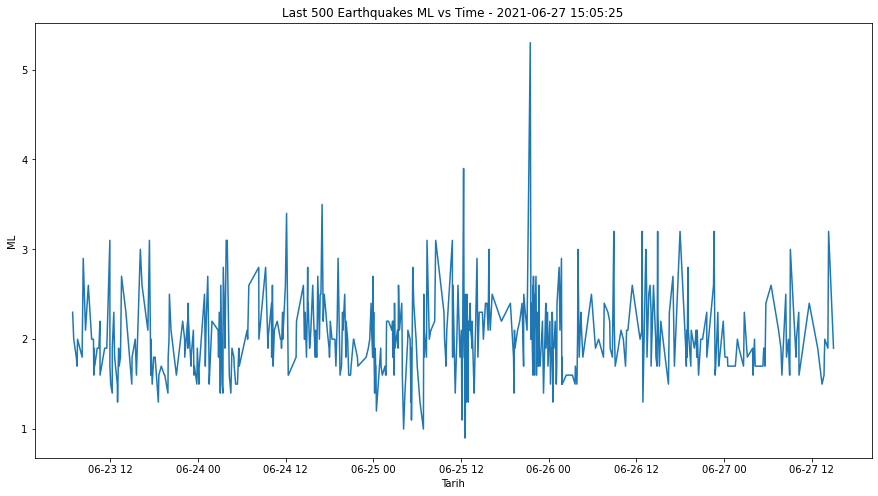

In [279]:
plt.figure(figsize=(15,8))
plt.plot(df['TarihSaat'], df['ML'])
plt.xlabel('Tarih')
plt.ylabel('ML')
plt.title(f'Last 500 Earthquakes ML vs Time - {last_modified_time}')
plt.show()


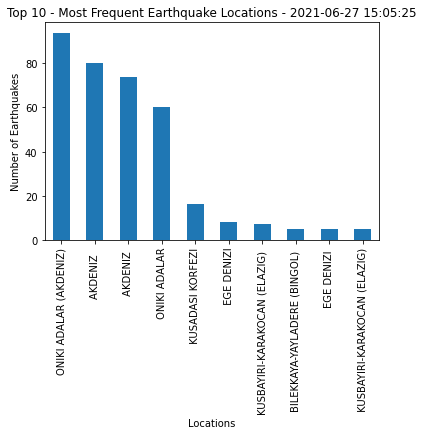

In [280]:
df['Yer'].value_counts().sort_values(ascending=False)[0:10].plot(kind='bar')
plt.title(f'Top 10 - Most Frequent Earthquake Locations - {last_modified_time}')
plt.ylabel('Number of Earthquakes')
plt.xlabel('Locations')
plt.show()

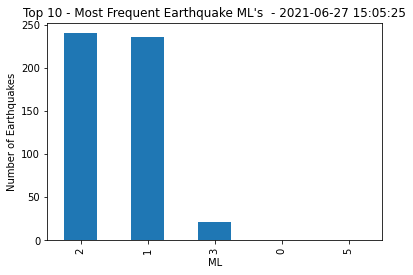

In [281]:
df['ML'].astype(int).value_counts().sort_values(ascending=False)[0:10].plot(kind='bar')
plt.title(f'Top 10 - Most Frequent Earthquake ML\'s  - {last_modified_time}')
plt.ylabel('Number of Earthquakes')
plt.xlabel('ML')
plt.show()

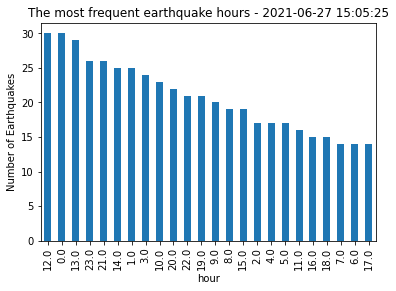

In [282]:
df['hour'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title(f'The most frequent earthquake hours - {last_modified_time}')
plt.xlabel('hour')
plt.ylabel('Number of Earthquakes')
plt.show()

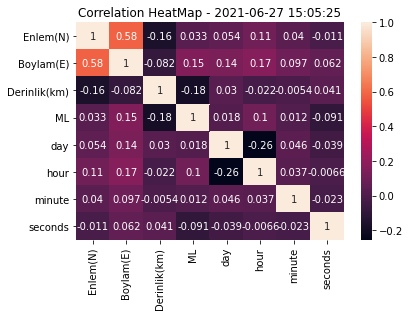

In [283]:
corr = df.drop(['Yer','year','month'],axis=1).corr()
sn.heatmap(corr,annot=True)
plt.title(f'Correlation HeatMap - {last_modified_time}')
plt.show()

Correlation heatmap shows, there is not a strong realtionship between features.
Maximum correlation ranks belong to Langitute, longtitue features, this can be due to the earthquakes happen in the east of th country at that time, we extract the Data 

## 2.1 Outliers

### 2.1.1 Isolation Forest

Find outlier earthquake samples in the dataset by IsolationForest

In [284]:
isf = IsolationForest()

In [285]:
X= df.drop(['TarihSaat','Yer'],axis=1)

In [286]:
isf.fit(X)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [287]:
outliers = np.where(isf.predict(X)==-1)[0]

In [288]:
df['isoutlier'] =0
df.iloc[outliers,-1] =1

In [289]:
df.head()

,Enlem(N),Boylam(E),Derinlik(km),ML,Yer,TarihSaat,year,month,day,hour,minute,seconds,isoutlier
0,36.2388,27.1667,24.0,1.9,AKDENIZ,2021-06-27 14:57:53,2021.0,6.0,27.0,14.0,57.0,53.0,1
1,36.3288,27.0918,20.0,3.2,AKDENIZ,2021-06-27 14:17:25,2021.0,6.0,27.0,14.0,17.0,25.0,1
2,36.3502,27.2070,25.4,1.9,ONIKI ADALAR (AKDENIZ),2021-06-27 14:11:31,2021.0,6.0,27.0,14.0,11.0,31.0,0
3,36.4165,27.0785,9.9,2.0,ONIKI ADALAR,2021-06-27 13:46:10,2021.0,6.0,27.0,13.0,46.0,10.0,0
4,36.2845,27.0868,23.9,1.8,AKDENIZ,2021-06-27 13:42:21,2021.0,6.0,27.0,13.0,42.0,21.0,0


In [290]:
def createMap(df):
  latitude = df['Enlem(N)'].mean()
  longitude = df['Boylam(E)'].mean()
  colurs = ['#0000FF','#FF0000']
  # create map
  map_earthquakes = folium.Map(location=[latitude,longitude],zoom_start=7)
  # add markers to the map
  markers_colors = []
  for lat, lon, yer, derinlik, ml,zaman, outlier in zip(df['Enlem(N)'], df['Boylam(E)'],df['Yer'] ,df['Derinlik(km)'],df['ML'],df['TarihSaat'],df['isoutlier']):
    label = folium.Popup( parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5*ml,
        popup="Yer:"+ str(yer)+"\nTarih:"+str(zaman)+"\nŞiddet:"+str(ml) +"\nDerinlik:"+str(derinlik),
        color=colurs[outlier],
        fill_color=colurs[outlier],
        fill=True,
        fill_opacity=0.7).add_to(map_earthquakes)
  print(f'Last 500 Earthquakes in (or near) Turkey - {last_modified_time}')
  return map_earthquakes

**Outlier Detection with Isolation Forest**

In [291]:
createMap(df)

Last 500 Earthquakes in (or near) Turkey - 2021-06-27 15:05:25


In the map, each point represents an Eartquake,
the red points are outliers.
ML determines the radius of points. Bigger earthquakes are represented as bigger points.

# 3. ML Application

First, I will try to predict ML of the data with linear and ensemble models

* Linear Regression Model

In [292]:
y = df['ML']
X = df.drop(['TarihSaat','Yer','ML','isoutlier','year',	'month'],axis=1)

In [293]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [294]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=42)

In [295]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print('Linear Regression Model mean squares error is: ',mean_squared_error(y_test,y_pred))
print('Linear Regression Model R^2 is: ',lr.score(X_test,y_test))

Linear Regression Model mean squares error is:  0.21988540596885683
Linear Regression Model R^2 is:  0.004039940835456446


In [296]:
weighs = lr.coef_
features=X.columns

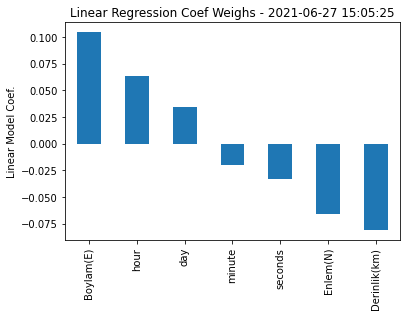

In [297]:
pd.Series(weighs, index=features).sort_values(ascending=False).plot(kind='bar')
plt.title(f'Linear Regression Coef Weighs - {last_modified_time}')
plt.ylabel('Linear Model Coef.')
plt.show()

Boylam(E)-Longitute effects ML positively. This is due to the last big earthquakes happen in the east of Turkey (Elazığ,5.3) soon.

Derinlik(km)-Depth effects ML negatively. Shallow earthquakes, make bigger ML. This can be also the feature of last earthquakes only

Enlem(N)-Latitude effects ML negatively, norther locations have smaller ML earthquakes locations in Turkey

* Random Forest Regression Model

In [298]:
y = df['ML']
X = df.drop(['TarihSaat','Yer','ML','isoutlier','year',	'month'],axis=1)
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=42)

In [299]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print('Random Forest Regression Model mean squares error is: ',mean_squared_error(y_test,y_pred))
print('Random Forest Regression Model R^2 is: ',rfr.score(X_test,y_test))

Random Forest Regression Model mean squares error is:  0.17297779333333335
Random Forest Regression Model R^2 is:  0.2165056497345742


MSE of Random Forest Regressor Model is less than Linnear Regression Model, which means Random Forest Model makes better estimates. Random Forest Model's R^2 is also better than Linear Regression Model, but it is very low. (R^2 is between 1 and -1, and low values mean data does not represent the model well). This can be due to data. We can not generalize a model with this data.

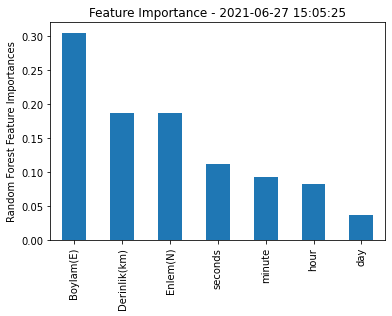

In [300]:
pd.Series(rfr.feature_importances_, index=features).sort_values(ascending=False).plot(kind='bar')
plt.title(f'Feature Importance - {last_modified_time}')
plt.ylabel('Random Forest Feature Importances')
plt.show()

Similar to linear model, boylam(E)-longitute is the strongest feature effecting ML, This result shows the location features of last earthquakes